In [1]:
import os
from itertools import count

import shapefile
import contextily as cx
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import geopandas
import osmnx as ox
import pandas as pd
from tqdm.auto import tqdm
from libpysal.cg import voronoi_frames
import momepy
import math
import shapely
shapely.speedups.disable()

import seaborn as sns

sns.set_theme(context='poster', style="whitegrid")

DATA = "data"

/usr/local/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [9]:
G = nx.read_gpickle('data/shortest_paths_counter.gpickle')

In [10]:


total_length = 0
for u,v,a in G.edges(data=True):
    if 'additional' in a.keys() and a['additional'] == 'new_bike_path':
         total_length += a['length']

In [11]:
total_length / 1000

653.8667797675932

Różna długość całkowita, chyba ta druga bardziej poprawna, bo nie uwzględnia nakładania się.

## Wizualizacja

In [12]:
G_nodes, G_streets = ox.graph_to_gdfs(G)

G_nodes = G_nodes.to_crs(epsg=2177)
G_streets = G_streets.to_crs(epsg=2177)

In [27]:
min_counts = np.sort(G_streets.bike_counter.unique())

In [38]:
total_lengths = []

for min_count in tqdm(min_counts):
    total_length = 0
    for u,v,a in G.edges(data=True):
        if 'additional' in a.keys() and a['additional'] == 'new_bike_path' and a['bike_counter'] >= min_count:
             total_length += a['length']
    
    total_lengths.append(total_length / 1000)

  0%|          | 0/35 [00:00<?, ?it/s]

In [46]:
for mc, t in zip(min_counts, total_lengths):
    print(f'{mc}: {t:.2f}km')

0: 653.87km
1: 653.87km
2: 287.62km
3: 172.38km
4: 131.94km
5: 90.47km
6: 75.07km
7: 60.31km
8: 52.44km
9: 43.29km
10: 35.00km
11: 26.61km
12: 23.66km
13: 22.18km
14: 19.10km
15: 16.42km
16: 13.08km
17: 11.89km
18: 11.17km
19: 10.95km
20: 10.11km
21: 9.53km
22: 9.27km
23: 8.02km
24: 8.02km
25: 7.78km
26: 7.28km
27: 6.45km
31: 5.75km
33: 4.91km
35: 3.88km
36: 3.79km
38: 2.23km
39: 1.93km
43: 1.92km


Text(0, 0.5, 'Całkowita długość [km]')

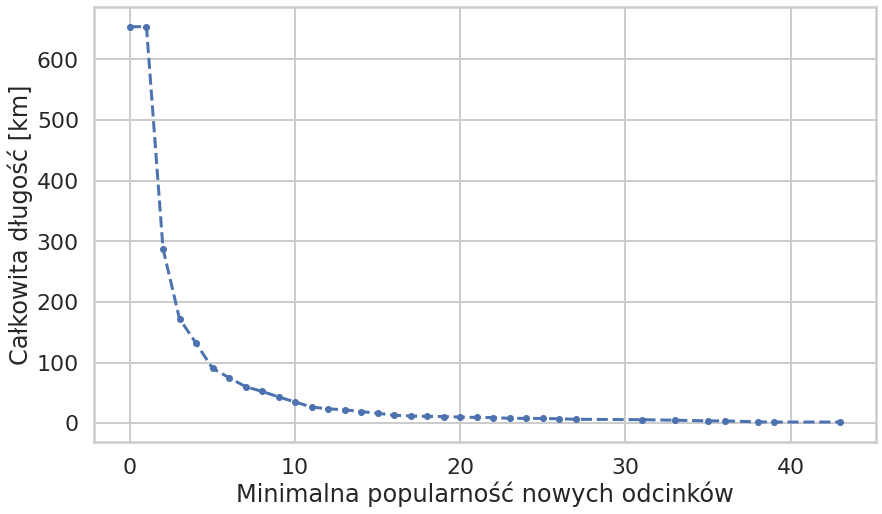

In [40]:
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(min_counts, total_lengths, '.--')
ax.set_xlabel('Minimalna popularność nowych odcinków')
ax.set_ylabel('Całkowita długość [km]')

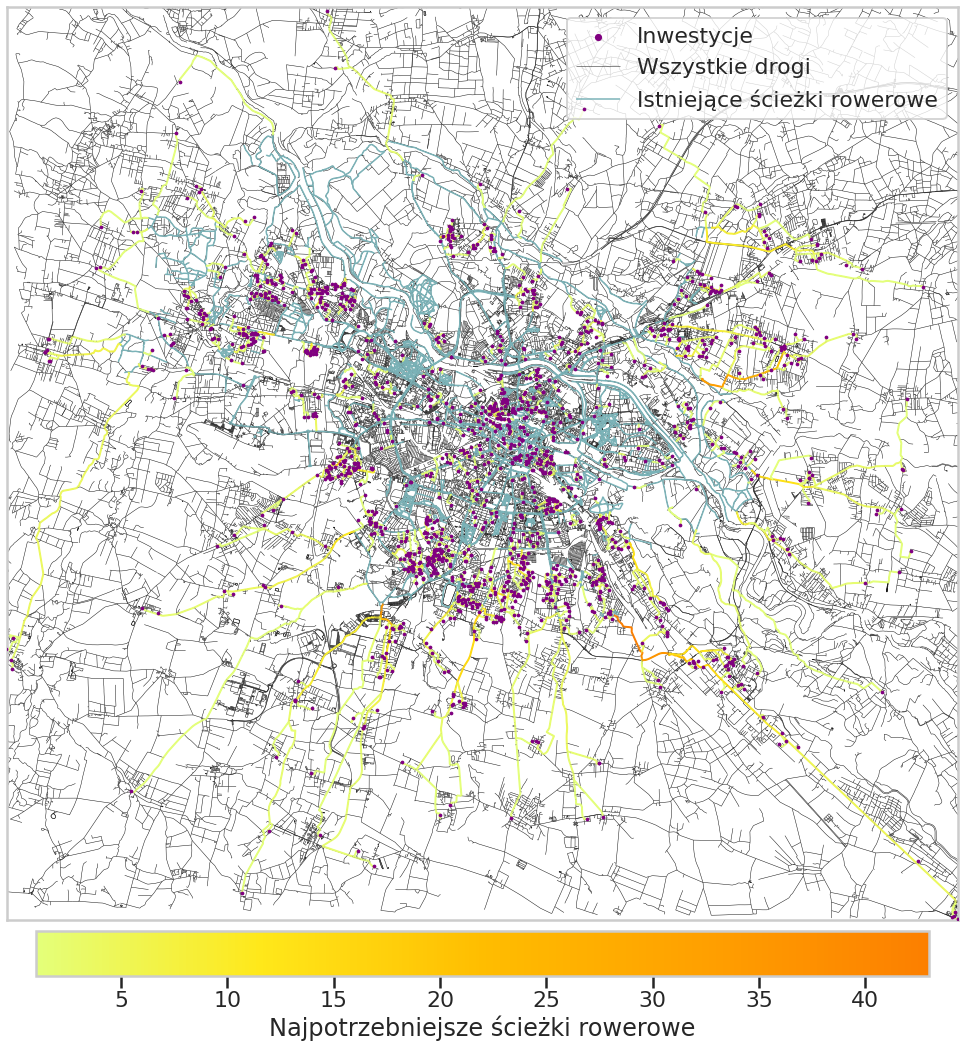

In [58]:
fig = plt.figure(figsize=(20,20))
ax = plt.subplot()

G_nodes[G_nodes['type'] == 'building'].plot(
    markersize=3, color='purple', ax=ax, zorder=7, label='Inwestycje'
)

G_streets[G_streets['type'] == 'all_road'].plot(
    ax=ax, alpha=1, linewidth=0.5, edgecolor='k', label='Wszystkie drogi'
)

G_streets[G_streets['type'] == 'bike_path'].plot(
    ax=ax, alpha=1, linewidth=1.5, edgecolor='#7bb3b8', label='Istniejące ścieżki rowerowe'
)

# min_count_val = 10
# new_bike_roads = G_streets[(G_streets.get('additional') == 'new_bike_path') & 
#                            (G_streets.get('bike_counter') >= min_count_val)]
# new_bike_roads.plot(column='bike_counter',
#     ax=ax, alpha=1, linewidth=2, edgecolor='red'
# )
# new_bike_roads.plot(column='bike_counter',
#     ax=ax, alpha=1, linewidth=2, legend=True,
#     legend_kwds={'pad': 0.01,  'shrink': 0.8, 'label': "Liczba powtarzających się nowych ścieżek rowerowych", 
#                   'orientation': "horizontal"}
# )

G_streets[G_streets.get('additional') == 'new_bike_path'].plot(column='bike_counter',
        linewidth=2, ax=ax, legend=True, cmap='Wistia', 
        legend_kwds={'label': "Najpotrzebniejsze ścieżki rowerowe",
                     'orientation': "horizontal",'pad': 0.01, 'shrink': 0.8} 
)

ax.legend(markerscale=3)

ax.set_ylim(bottom=5.6461e6, top=5.6803e6)
ax.set_xlim(left=6.4134e6, right=6.449e6)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('image/bike_counter.png', dpi=400, bbox_inches='tight')

# fig.savefig('image/shortest_paths_adjusted_no_cx.jpg', dpi=400, bbox_inches='tight')
# cx.add_basemap(ax=ax, crs=G_nodes.crs.to_string(), source=cx.providers.CartoDB.Voyager)
# plt.savefig('image/shortest_paths.jpg')

In [15]:
# cx.add_basemap(ax=ax, crs=G_nodes.crs.to_string(), source=cx.providers.CartoDB.VoyagerNoLabels)
# fig.savefig('image/shortest_paths_adjusted.jpg', dpi=400, bbox_inches='tight')
# fig